## ARI2101 – Fundamentals of Automated Planning Project

#### Isaac Muscat - 0265203L
#### Matthias Bartolo - 0436103L
#### Jerome Agius - 0353803L

# Packages

In [1]:
#Importing and installing necessary packages 
!pip install matplotlib
import time
import queue
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
width=3
height=3

# Puzzle Board Representation

In [3]:
#Declaring Puzzle class which holds an instance of a board
class Puzzle:
    
    #Creating Shared variable which stores the number of created states
    stateCounter = 0
    #Creating Shared variable which stores the number of unique explored/unexplored states
    noOfUniqueStates=0
    
    #Puzzle Constructor which includes the following variables:
    # 1. currentState - which holds the current state of the board
    # 2. parentState - which holds the previous/parent state of the board
    # 3. action - which holds the action applied to achieve the current state from the parent state of the board
    # 4. nodeId - which holds a unique node Id used to distinguish between nodes (mainly utilised for A* Search)
    # 5. costToReachNode - which holds the actual cost to reach the current node, in other words, g(n)
    def __init__(self, currentState, parentState, action, nodeId, costToReachNode):
        self.currentState = currentState 
        self.parentState = parentState
        self.action = action 
        self.nodeId = nodeId
        self.costToReachNode = costToReachNode;
        #Incrementing the state counter every time a Puzzle instance is created
        Puzzle.stateCounter += 1
        
    #Declaring a Method which generates new children nodes
    def generateChildren(self):
        #Declaring a list which holds new child instances of the board
        childrenStates = []
        
        #Retrieving the location of the empty slot
        emptyLocation = self.currentState.index(0)
        
        #Checking if the empty location (0) is at the right column
        if(int(emptyLocation%width) != (width-1)): 
            #Making a copy of the board & swapping values
            temp = self.currentState.copy()
            temp[emptyLocation], temp[emptyLocation+1] = temp[emptyLocation+1], temp[emptyLocation]
            #Appending the valid Puzzle action to the list
            childrenStates.append(Puzzle(temp, self, "Slide Left", Puzzle.stateCounter, self.costToReachNode + 1))
        
        #Checking if the empty location (0) is at the left column
        if(int(emptyLocation%width) != 0): 
            #Making a copy of the board & swapping values
            temp = self.currentState.copy()
            temp[emptyLocation], temp[emptyLocation-1] = temp[emptyLocation-1], temp[emptyLocation]
            #Appending the valid Puzzle action to the list
            childrenStates.append(Puzzle(temp, self, "Slide Right", Puzzle.stateCounter, self.costToReachNode + 1))

        #Checking if the empty location (0) is at the top row
        if(int(emptyLocation/height) != 0): 
            #Making a copy of the board & swapping values
            temp = self.currentState.copy()
            temp[emptyLocation], temp[emptyLocation-width] = temp[emptyLocation-width], temp[emptyLocation]
            #Appending the valid Puzzle action to the list
            childrenStates.append(Puzzle(temp, self, "Slide Down", Puzzle.stateCounter, self.costToReachNode + 1))
            
        #Checking if the empty location (0) is at the lowest row 
        if(len(temp)>emptyLocation+width):
            #Making a copy of the board & swapping values
            temp = self.currentState.copy()
            temp[emptyLocation], temp[emptyLocation+width] = temp[emptyLocation+width], temp[emptyLocation]
            #Appending the valid Puzzle action to the list
            childrenStates.append(Puzzle(temp, self, "Slide Up", Puzzle.stateCounter, self.costToReachNode + 1))


            
        #Returning the childrenStates list
        return childrenStates
    
    #Declaring a Method which backtracks the graph when the goal is found, to output the whole solution
    def backtrackSolution(self):
        #Creating empty array to hold solution of the problem
        solution = []
        #Adding the current state of the board to the solution
        solution.append(self)
        #Declaring a variable used to backtrack to the initial node, and initialising it to self
        previousState = self
        #Looping until the initial state is found, since initial state does not have any parents
        while(previousState.parentState != None):
            #Resetting previousState to hold the parentState of the previous State
            previousState = previousState.parentState
            #Adding the previous state of the board to the solution
            solution.append(previousState)
        #Since at every step we are appending to the back of the list, instead of appending to
        #the beginning, we reverse the list to obtain the correct solution order
        solution.reverse()
        #Returning solution
        return solution
    
#Declaring a Method which checks if goal state has been found
def goalFound(currentState):
    #Checking if current state matches the goals
    goal=list(range(width*height))
    goal.remove(0)
    goal.append(0)
    if(currentState == goal):
        return True
    return False

#Declaring a Method which counts the number of inversions
def countInversions(puzzleboard):
    #Declaring and initialising the counter to 0
    counter = 0
    #Looping through all board contents, and for every cell, we are checking whether there are any inversions
    for i in range(0, width*height):
        for j in range(i + 1, width*height):
            #Checking if puzzleboard[i]>puzzleboard[j], then there exists an inversion, and we must increment counter by 1
            if (puzzleboard[i] != 0 and puzzleboard[j] != 0 and puzzleboard[i] > puzzleboard[j]):
                counter += 1
    return counter

# Heuristics

In [4]:
#Declaring a Heuristic function which counts the number of misplaced tiles, and returns a heuristic value
def CountMisplacedTiles(puzzleboard):
    goal=list(range(width*height))
    goal.remove(0)
    goal.append(0)
    HeuristicValue = 0
    #Looping through all the board locations and checking that the location is not an empty location, 
    #checking whether the tiles 
    #are in their correct position as stated in the goal, if not the heuristic value is updated
    for x in range(0,width*height):
        if (puzzleboard[x] != 0 and puzzleboard[x] != goal[x]):
                HeuristicValue += 1
    return HeuristicValue

#Declaring a Heuristic function which counts the sum of how far misplaced tiles are from their target position, 
#and returns a heuristic value
def ManhattanDistance(puzzleboard):
    goal=list(range(width*height))
    goal.remove(0)
    goal.append(0)
    HeuristicValue = 0
    #Looping through all the board locations and checking that the location is empty
    for x in range(width*height):
        if (puzzleboard[x] != 0):
            #Retrieving row and column position of current node
            rowboard = int(x / height) 
            columnboard = int(x % width)
            
            #Finding out the row and column position of current node in the goal
            nodeindex = goal.index(puzzleboard[x])
            rowgoal = int(nodeindex / height) 
            columngoal = int(nodeindex % width)
            #Performing the Manhattan Distance formula to obtain the result
            HeuristicValue += abs(rowboard-rowgoal) + abs(columnboard - columngoal)
    return HeuristicValue

#Declaring a Method to choose the heuristic function
def heuristicChoice(puzzleboard, heuristicNumber):
    #Invoking the appropriate method according to the past parameter
    if heuristicNumber == 1:
        return CountMisplacedTiles(puzzleboard)
    elif heuristicNumber == 2:
        return ManhattanDistance(puzzleboard)

# Breadth First Search

In [5]:
#Declaring a Method which performs Breadth First Search on a Puzzle
def BFS(puzzleboard,startTime):
    #Declaring a List to hold all explored nodes
    exploredList =set()
    unexploredBoardStates = set()
    #Checking if the initial state is a goal
    if(goalFound(puzzleboard.currentState)):
        Puzzle.noOfUniqueStates=1
        return puzzleboard.backtrackSolution()
    
    #Initialising a queue to store all the children
    unexploredList = queue.Queue()
    #Appending the initial puzzle to the queue
    unexploredList.put(puzzleboard)
    unexploredBoardStates.add(str(puzzleboard.currentState))

    #Looping until unexploredList is empty
    while not (unexploredList.empty()):
        #Checking if the time limit of 15 minutes has been exceeded, if so, the algorithm is stopped
        currentTime=time.time()
        if((currentTime-startTime)>15*60):
            print("Exceeded Time limit!\nAlgorithm Stopped")
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=unexploredList.qsize()+len(exploredList)
            return puzzleboard.backtrackSolution()
        #Retrieving the front node from the queue and appending its current state to exploredList
        node = unexploredList.get()
        unexploredBoardStates.remove(str(node.currentState))
        exploredList.add(str(node.currentState))

        #Checking if the current state is the goal state, if so we backtrack from that current state
        if(goalFound(node.currentState)):
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=unexploredList.qsize()+len(exploredList)
            return node.backtrackSolution()
        
        #Retrieving the next layer of children for the current node 
        childrenStatesList = node.generateChildren()
        
        #Checking if any of the current children are the goal state if so we backtrack from that child state
        for child in childrenStatesList:
            if((str(child.currentState) not in exploredList) and (str(child.currentState) not in unexploredBoardStates)):
                if(goalFound(child.currentState)):
                    #Setting the number of unique states to the number of explored nodes and unexplored nodes
                    Puzzle.noOfUniqueStates=unexploredList.qsize()+len(exploredList)
                    return child.backtrackSolution()
                #Appending the child puzzle to unexploredList    
                unexploredList.put(child)
                unexploredBoardStates.add(str(child.currentState))

# Greedy Best First Search

In [6]:
#Declaring a Method which performs Greedy Best First Search on a Puzzle
def GBFS(puzzleboard, heuristicNumber,startTime):
    #Declaring a List to hold all explored nodes
    exploredList = set()

    #Checking if the initial state is a goal
    if(goalFound(puzzleboard.currentState)):
        Puzzle.noOfUniqueStates=1
        return puzzleboard.backtrackSolution()

    #Initialising a list to store all the children
    unexploredList = []
    unexploredBoardStates = set()
    
    #Appending the initial puzzle to the queue
    heapq.heappush(unexploredList, (heuristicChoice(puzzleboard.currentState, heuristicNumber), puzzleboard.nodeId, 
                                    puzzleboard))
    unexploredBoardStates.add(str(puzzleboard.currentState))
    
    #Looping until unexploredList is empty
    while (unexploredList != []):
        #Checking if the time limit of 15 minutes has been exceeded, if so, the algorithm is stopped
        currentTime=time.time()
        if((currentTime-startTime)>15*60):
            print("Exceeded Time limit!\nAlgorithm Stopped")
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
            return puzzleboard.backtrackSolution()
        
        #Retrieving front node from the queue and appending its current state to exploredList
        heuristic,stateCounter,node = heapq.heappop(unexploredList)
        unexploredBoardStates.remove(str(node.currentState))
        exploredList.add(str(node.currentState))
        
        #Checking if the current state is the goal state, if so we backtrack from that current state
        if(goalFound(node.currentState)):
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
            return node.backtrackSolution()

        #Retrieving next layer of children for node 
        childrenStatesList = node.generateChildren()

        #Checking if any of the current children are the goal state if so we backtrack from that child state
        for child in childrenStatesList:
            if((str(child.currentState) not in exploredList) and (str(child.currentState) not in unexploredBoardStates)):
                if(goalFound(child.currentState)):
                    #Setting the number of unique states to the number of explored nodes and unexplored nodes
                    Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
                    return child.backtrackSolution()
                #Appending the optimal child puzzle to unexploredList
                heapq.heappush(unexploredList, (heuristicChoice(child.currentState, heuristicNumber), child.nodeId, child))
                unexploredBoardStates.add(str(child.currentState))

# A* Search

In [7]:
#Declaring a Method which performs Greedy Best First Search on a Puzzle
def Astar(puzzleboard, heuristicNumber,startTime):
    #Declaring a List to hold all explored nodes
    exploredList = dict()

    #Checking if the initial state is a goal
    if(goalFound(puzzleboard.currentState)):
        Puzzle.noOfUniqueStates=1
        return puzzleboard.backtrackSolution()

    #Initialising a list to store all the children
    unexploredList = []
    unexploredBoardStates = set()
    #Appending the initial puzzle to the queue
    heapq.heappush(unexploredList, (heuristicChoice(puzzleboard.currentState, heuristicNumber) 
                                    + puzzleboard.costToReachNode, puzzleboard.nodeId, puzzleboard))
    unexploredBoardStates.add(str(puzzleboard.currentState))
    #Looping until unexploredList is empty
    while (unexploredList != []):
        #Checking if the time limit of 15 minutes has been exceeded, if so, the algorithm is stopped
        currentTime=time.time()
        if((currentTime-startTime)>15*60):
            print("Exceeded Time limit!\nAlgorithm Stopped")
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
            return puzzleboard.backtrackSolution()
        
        #Retrieving front node from the queue and appending its current state to exploredList
        heuristic,stateCounter,node = heapq.heappop(unexploredList)
        unexploredBoardStates.remove(str(node.currentState))
        exploredList[str(node.currentState)]=node.costToReachNode
        #Checking if the current state is the goal state, if so we backtrack from that current state
        if(goalFound(node.currentState)):
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
            return node.backtrackSolution()

        #Retrieving next layer of children for node 
        childrenStatesList = node.generateChildren()

        #Checking if any of the current children are the goal state if so we backtrack from that child state
        for child in childrenStatesList:
            if(str(child.currentState) not in exploredList and str(child.currentState) not in unexploredBoardStates):
                if(goalFound(child.currentState)):
                    #Setting the number of unique states to the number of explored nodes and unexplored nodes
                    Puzzle.noOfUniqueStates=len(unexploredList)+len(exploredList)
                    return child.backtrackSolution()
                #Appending the optimal child puzzle to unexploredList
                heapq.heappush(unexploredList, (heuristicChoice(child.currentState, heuristicNumber) 
                                                + child.costToReachNode, child.nodeId, child))
                unexploredBoardStates.add(str(child.currentState))
            #Updating cost of node, if current child node cost is less
            elif(str(child.currentState) in exploredList):
                cost=exploredList[str(child.currentState)]
                if(cost>child.costToReachNode):
                    exploredList[str(child.currentState)]=child.costToReachNode

# Enforced Hill Climbing

In [8]:
#Declaring a Method which performs Enforced Hill Climbing on a Puzzle
def EHCS(puzzleboard, heuristicNumber,startTime):
    exploredList = set()
    unexploredBoardStates = set()
    Puzzle.noOfUniqueStates=1
    #Checking if first state is a goal
    if(goalFound(puzzleboard.currentState)):
        Puzzle.noOfUniqueStates=1
        return puzzleboard.backtrackSolution()
    #Initialising a queue to store all the children
    unexploredList = queue.Queue()
    #Calculating the heuristic of the current state and setting it as the bestHeuristic
    bestHeuristic = heuristicChoice(puzzleboard.currentState, heuristicNumber)
    #Append the initial puzzle to the queue
    unexploredList.put(puzzleboard)
    unexploredBoardStates.add(str(puzzleboard.currentState))

    #Loop until unexploredList is empty
    while not (unexploredList.empty()):
        #Checking if the time limit of 15 minutes has been exceeded, if so, the algorithm is stopped
        currentTime=time.time()
        if((currentTime-startTime)>15*60):
            print("Exceeded Time limit!\nAlgorithm Stopped")
            return puzzleboard.backtrackSolution()
        #Retrieving front node from the queue and appending its current state to exploredList
        node = unexploredList.get()
        exploredList.add(str(node.currentState))
        #Checking if the current state is the goal state, if so we backtrack from that current state
        if(goalFound(node.currentState)):
            #Setting the number of unique states to the number of explored nodes and unexplored nodes
            return node.backtrackSolution()
        
        #Retrieving next layer of children for node 
        childrenStatesList = []
        childrenStatesList = node.generateChildren()
        #Checking if any of the current children are the goal state if so we backtrack from that child state
        for child in childrenStatesList:
            if((str(child.currentState) not in exploredList) and (str(child.currentState) not in unexploredBoardStates)):
                #Calculating the heuristic of the child state and assigning it to cost
                cost = heuristicChoice(child.currentState, heuristicNumber)
                Puzzle.noOfUniqueStates+=1
                if(goalFound(child.currentState)):
                    return child.backtrackSolution()
                #Checking if the cost of the child is less than that of the current state, assigning the cost to bestHeuristic, 
                #clearing unexploredList, appending the child to it and breaking from the loop
                if (cost < bestHeuristic):
                    bestHeuristic = cost
                    unexploredList.queue.clear()
                    unexploredList.put(child)
                    unexploredBoardStates.add(str(child.currentState))
                    break
                #Appending the child to unexploredList
                unexploredList.put(child)    
                unexploredBoardStates.add(str(child.currentState))
    #Checking if Enforced Hill Climbing fails and if so falling back to A* Search
    print("Fallback Solution")
    return Astar(puzzleboard, heuristicNumber, time.time())

# Combined Main Method

In [9]:
#Declaring a Method which executes the EHCS method and calculate performance statistics
def Main(array, heuristicNumber, algorithmOption):
    
    #Setting the initial stateCounter and puzzleboard
    Puzzle.stateCounter = 0
    Puzzle.noOfUniqueStates=0
    puzzleboard = Puzzle(array, None, None, 0, 0)
    
    #Starting to measure, the time for the algorithm
    startTime = time.time()
    
    
    if (algorithmOption == 0):
         #Execute BFS on the initial puzzleboard
        solution = BFS(puzzleboard,startTime)
    elif (algorithmOption == 1):
         #Execute GBFS on the initial puzzleboard
        solution = GBFS(puzzleboard, heuristicNumber, startTime)
    elif (algorithmOption == 2):
        #Execute Astar on the initial puzzleboard
        solution = Astar(puzzleboard, heuristicNumber, startTime)
    elif (algorithmOption == 3):
        #Execute Enforced Hill Climbing on the initial puzzleboard
        solution = EHCS(puzzleboard, heuristicNumber, startTime)
    
    #Stopping the time, since algorithm terminated
    endTime = time.time()
    
    #Representing the solution in a 3 by 3 matrix
    solutionArray = np.array(solution)
    
    #Printing all the board states & actions present in the solution
    for i in range(len(solutionArray)):
        if(i!=0):
            print(solution[i].action)
        print(np.array(solution[i].currentState).reshape((height, width)))
        print()

    #Returning performance statistics
    return len(solution)-1, Puzzle.noOfUniqueStates, round((endTime - startTime), 3)

# Evaluation

In [10]:
#Declaring a method which plots a bar graph denoting the differences between the sorting algorithms
def createBarChart(title, xlabel, ylabel, barHeight):
    bars = ['BFS', 'GBFS\n(MD)', 'GBFS\n(MT)', 'A*\n(MD)', 'A*\n(MT)', 'EHC\n(MD)', 'EHC\n(MT)', 'PDDL']
    
    #The label locations
    x = np.arange(len(bars)) 
    
    #The width of the bars
    width = 0.35 

    fig, ax = plt.subplots()
    
    #Setting graph x/y labels & title
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(bars)
    
    pps = ax.bar(x, barHeight, width, label='value')
    
    #Printing appropriate label values over bars 
    for p in pps:
        height = p.get_height()
        ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()

In [11]:
#Declaring a method which takes a passed puzzle and displays three bar charts to analyse each search technique's actions taken,
#states discovered and time taken to execute
def Evaluation(puzzle):
    #Declaring three lists for the three performance statistics
    actionsList = []
    statesList = []
    timeList = []
    #Appending the performance statistics to their corresponding list for each search technique
    print("\nBreadth First Search ")
    actions, states, timeVal = Main(puzzle, 0, 0)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nGreedy Best First Search (Manhattan Distance) ")
    actions, states, timeVal = Main(puzzle, 2, 1)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nGreedy Best First Search (Misplaced Tiles) ")
    actions, states, timeVal = Main(puzzle, 1, 1)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nA* Search (Manhattan Distance) ")
    actions, states, timeVal = Main(puzzle, 2, 2)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nA* Search (Misplaced Tiles) ")
    actions, states, timeVal = Main(puzzle, 1, 2)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nEnforced Hill Climbing (Manhattan Distance) ")
    actions, states, timeVal = Main(puzzle, 2, 3)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nEnforced Hill Climbing (Misplaced Tiles) ")
    actions, states, timeVal = Main(puzzle, 1, 3)
    actionsList.append(actions)
    statesList.append(states)
    timeList.append(timeVal)
    print("\nPDDL ")
    #actions, states, timeVal = Main(puzzle, 1, 3)
    actionsList.append(37)
    statesList.append(248)
    timeList.append(0.004)

    #Creating a bar chart for each performance statistic list
    createBarChart("States Vs Search Techniques", "Search Techniques", "States", statesList)
    createBarChart("Actions Vs Search Techniques", "Search Techniques", "Actions", actionsList)
    createBarChart("Time Vs Search Techniques", "Search Techniques", "Time/s", timeList)

# Main Menu Interface

ARI2101 – Fundamentals of Automated Planning Project
Input the  3 x 3  sliding tile configuration (0 to mark an empty location and tiles from 1 to  9 ): 

Input tile at location: 1
8
Input tile at location: 2
6
Input tile at location: 3
7
Input tile at location: 4
2
Input tile at location: 5
5
Input tile at location: 6
4
Input tile at location: 7
3
Input tile at location: 8
0
Input tile at location: 9
1
Valid Configuration
1. Breadth First Search 
2. Greedy Best First Search (Manhattan Distance) 
3. Greedy Best First Search (Misplaced Tiles) 
4. A* Search (Manhattan Distance) 
5. A* Search (Misplaced Tiles) 
6. Enforced Hill Climbing (Manhattan Distance) 
7. Enforced Hill Climbing (Misplaced Tiles) 
8. Exit
9. Evaluation

9
Evaluation:)

Breadth First Search 
[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Left
[[8 6 7]
 [2 5 4]
 [3 1 0]]

Slide Down
[[8 6 7]
 [2 5 0]
 [3 1 4]]

Slide Right
[[8 6 7]
 [2 0 5]
 [3 1 4]]

Slide Right
[[8 6 7]
 [0 2 5]
 [3 1 4]]

Slide Up
[[8 6 7]
 [3 2 5]
 [0 1 4]]

S

[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Down
[[8 6 7]
 [2 0 4]
 [3 5 1]]

Slide Right
[[8 6 7]
 [0 2 4]
 [3 5 1]]

Slide Down
[[0 6 7]
 [8 2 4]
 [3 5 1]]

Slide Left
[[6 0 7]
 [8 2 4]
 [3 5 1]]

Slide Up
[[6 2 7]
 [8 0 4]
 [3 5 1]]

Slide Up
[[6 2 7]
 [8 5 4]
 [3 0 1]]

Slide Left
[[6 2 7]
 [8 5 4]
 [3 1 0]]

Slide Down
[[6 2 7]
 [8 5 0]
 [3 1 4]]

Slide Right
[[6 2 7]
 [8 0 5]
 [3 1 4]]

Slide Right
[[6 2 7]
 [0 8 5]
 [3 1 4]]

Slide Up
[[6 2 7]
 [3 8 5]
 [0 1 4]]

Slide Left
[[6 2 7]
 [3 8 5]
 [1 0 4]]

Slide Down
[[6 2 7]
 [3 0 5]
 [1 8 4]]

Slide Left
[[6 2 7]
 [3 5 0]
 [1 8 4]]

Slide Down
[[6 2 0]
 [3 5 7]
 [1 8 4]]

Slide Right
[[6 0 2]
 [3 5 7]
 [1 8 4]]

Slide Right
[[0 6 2]
 [3 5 7]
 [1 8 4]]

Slide Up
[[3 6 2]
 [0 5 7]
 [1 8 4]]

Slide Left
[[3 6 2]
 [5 0 7]
 [1 8 4]]

Slide Down
[[3 0 2]
 [5 6 7]
 [1 8 4]]

Slide Left
[[3 2 0]
 [5 6 7]
 [1 8 4]]

Slide Up
[[3 2 7]
 [5 6 0]
 [1 8 4]]

Slide Right
[[3 2 7]
 [5 0 6]
 [1 8 4]]

Slide Right
[[3 2 7]
 [0 5 6]
 [1 8 4]]

Slide Up
[[3 2

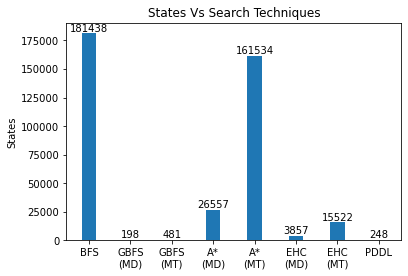

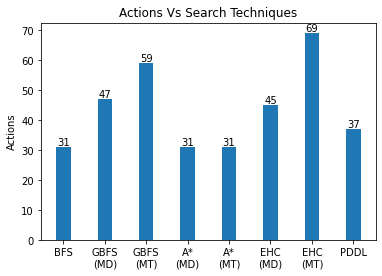

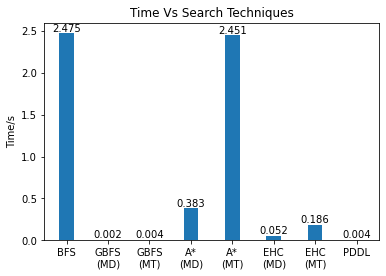

1. Breadth First Search 
2. Greedy Best First Search (Manhattan Distance) 
3. Greedy Best First Search (Misplaced Tiles) 
4. A* Search (Manhattan Distance) 
5. A* Search (Misplaced Tiles) 
6. Enforced Hill Climbing (Manhattan Distance) 
7. Enforced Hill Climbing (Misplaced Tiles) 
8. Exit
9. Evaluation

1
[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Left
[[8 6 7]
 [2 5 4]
 [3 1 0]]

Slide Down
[[8 6 7]
 [2 5 0]
 [3 1 4]]

Slide Right
[[8 6 7]
 [2 0 5]
 [3 1 4]]

Slide Right
[[8 6 7]
 [0 2 5]
 [3 1 4]]

Slide Up
[[8 6 7]
 [3 2 5]
 [0 1 4]]

Slide Left
[[8 6 7]
 [3 2 5]
 [1 0 4]]

Slide Left
[[8 6 7]
 [3 2 5]
 [1 4 0]]

Slide Down
[[8 6 7]
 [3 2 0]
 [1 4 5]]

Slide Down
[[8 6 0]
 [3 2 7]
 [1 4 5]]

Slide Right
[[8 0 6]
 [3 2 7]
 [1 4 5]]

Slide Right
[[0 8 6]
 [3 2 7]
 [1 4 5]]

Slide Up
[[3 8 6]
 [0 2 7]
 [1 4 5]]

Slide Left
[[3 8 6]
 [2 0 7]
 [1 4 5]]

Slide Down
[[3 0 6]
 [2 8 7]
 [1 4 5]]

Slide Right
[[0 3 6]
 [2 8 7]
 [1 4 5]]

Slide Up
[[2 3 6]
 [0 8 7]
 [1 4 5]]

Slide Up
[[2 3 6]
 [1 8 7

[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Left
[[8 6 7]
 [2 5 4]
 [3 1 0]]

Slide Down
[[8 6 7]
 [2 5 0]
 [3 1 4]]

Slide Down
[[8 6 0]
 [2 5 7]
 [3 1 4]]

Slide Right
[[8 0 6]
 [2 5 7]
 [3 1 4]]

Slide Right
[[0 8 6]
 [2 5 7]
 [3 1 4]]

Slide Up
[[2 8 6]
 [0 5 7]
 [3 1 4]]

Slide Up
[[2 8 6]
 [3 5 7]
 [0 1 4]]

Slide Left
[[2 8 6]
 [3 5 7]
 [1 0 4]]

Slide Left
[[2 8 6]
 [3 5 7]
 [1 4 0]]

Slide Down
[[2 8 6]
 [3 5 0]
 [1 4 7]]

Slide Right
[[2 8 6]
 [3 0 5]
 [1 4 7]]

Slide Right
[[2 8 6]
 [0 3 5]
 [1 4 7]]

Slide Up
[[2 8 6]
 [1 3 5]
 [0 4 7]]

Slide Left
[[2 8 6]
 [1 3 5]
 [4 0 7]]

Slide Left
[[2 8 6]
 [1 3 5]
 [4 7 0]]

Slide Down
[[2 8 6]
 [1 3 0]
 [4 7 5]]

Slide Right
[[2 8 6]
 [1 0 3]
 [4 7 5]]

Slide Down
[[2 0 6]
 [1 8 3]
 [4 7 5]]

Slide Left
[[2 6 0]
 [1 8 3]
 [4 7 5]]

Slide Up
[[2 6 3]
 [1 8 0]
 [4 7 5]]

Slide Right
[[2 6 3]
 [1 0 8]
 [4 7 5]]

Slide Down
[[2 0 3]
 [1 6 8]
 [4 7 5]]

Slide Right
[[0 2 3]
 [1 6 8]
 [4 7 5]]

Slide Up
[[1 2 3]
 [0 6 8]
 [4 7 5]]

Slide Up
[[1 2

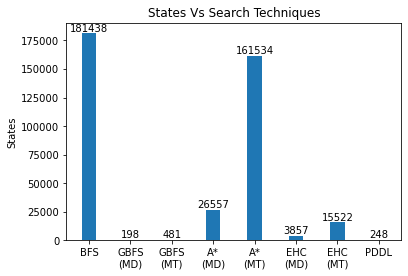

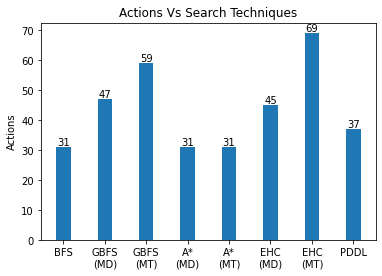

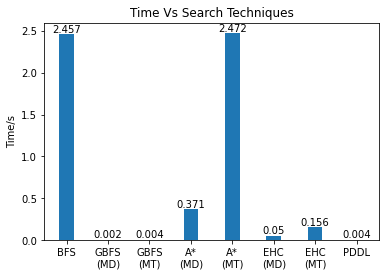

1. Breadth First Search 
2. Greedy Best First Search (Manhattan Distance) 
3. Greedy Best First Search (Misplaced Tiles) 
4. A* Search (Manhattan Distance) 
5. A* Search (Misplaced Tiles) 
6. Enforced Hill Climbing (Manhattan Distance) 
7. Enforced Hill Climbing (Misplaced Tiles) 
8. Exit
9. Evaluation

9
Evaluation:)

Breadth First Search 
[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Left
[[8 6 7]
 [2 5 4]
 [3 1 0]]

Slide Down
[[8 6 7]
 [2 5 0]
 [3 1 4]]

Slide Right
[[8 6 7]
 [2 0 5]
 [3 1 4]]

Slide Right
[[8 6 7]
 [0 2 5]
 [3 1 4]]

Slide Up
[[8 6 7]
 [3 2 5]
 [0 1 4]]

Slide Left
[[8 6 7]
 [3 2 5]
 [1 0 4]]

Slide Left
[[8 6 7]
 [3 2 5]
 [1 4 0]]

Slide Down
[[8 6 7]
 [3 2 0]
 [1 4 5]]

Slide Down
[[8 6 0]
 [3 2 7]
 [1 4 5]]

Slide Right
[[8 0 6]
 [3 2 7]
 [1 4 5]]

Slide Right
[[0 8 6]
 [3 2 7]
 [1 4 5]]

Slide Up
[[3 8 6]
 [0 2 7]
 [1 4 5]]

Slide Left
[[3 8 6]
 [2 0 7]
 [1 4 5]]

Slide Down
[[3 0 6]
 [2 8 7]
 [1 4 5]]

Slide Right
[[0 3 6]
 [2 8 7]
 [1 4 5]]

Slide Up
[[2 3 6]
 [0 8 7]


[[8 6 7]
 [2 5 4]
 [3 0 1]]

Slide Down
[[8 6 7]
 [2 0 4]
 [3 5 1]]

Slide Right
[[8 6 7]
 [0 2 4]
 [3 5 1]]

Slide Down
[[0 6 7]
 [8 2 4]
 [3 5 1]]

Slide Left
[[6 0 7]
 [8 2 4]
 [3 5 1]]

Slide Up
[[6 2 7]
 [8 0 4]
 [3 5 1]]

Slide Up
[[6 2 7]
 [8 5 4]
 [3 0 1]]

Slide Left
[[6 2 7]
 [8 5 4]
 [3 1 0]]

Slide Down
[[6 2 7]
 [8 5 0]
 [3 1 4]]

Slide Right
[[6 2 7]
 [8 0 5]
 [3 1 4]]

Slide Right
[[6 2 7]
 [0 8 5]
 [3 1 4]]

Slide Up
[[6 2 7]
 [3 8 5]
 [0 1 4]]

Slide Left
[[6 2 7]
 [3 8 5]
 [1 0 4]]

Slide Down
[[6 2 7]
 [3 0 5]
 [1 8 4]]

Slide Left
[[6 2 7]
 [3 5 0]
 [1 8 4]]

Slide Down
[[6 2 0]
 [3 5 7]
 [1 8 4]]

Slide Right
[[6 0 2]
 [3 5 7]
 [1 8 4]]

Slide Right
[[0 6 2]
 [3 5 7]
 [1 8 4]]

Slide Up
[[3 6 2]
 [0 5 7]
 [1 8 4]]

Slide Left
[[3 6 2]
 [5 0 7]
 [1 8 4]]

Slide Down
[[3 0 2]
 [5 6 7]
 [1 8 4]]

Slide Left
[[3 2 0]
 [5 6 7]
 [1 8 4]]

Slide Up
[[3 2 7]
 [5 6 0]
 [1 8 4]]

Slide Right
[[3 2 7]
 [5 0 6]
 [1 8 4]]

Slide Right
[[3 2 7]
 [0 5 6]
 [1 8 4]]

Slide Up
[[3 2

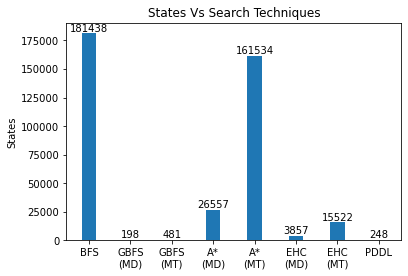

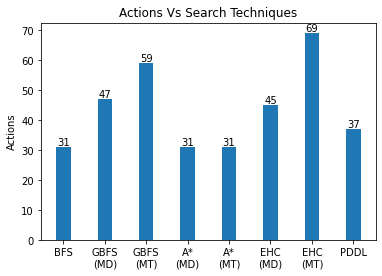

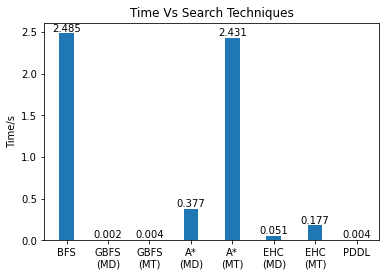

1. Breadth First Search 
2. Greedy Best First Search (Manhattan Distance) 
3. Greedy Best First Search (Misplaced Tiles) 
4. A* Search (Manhattan Distance) 
5. A* Search (Misplaced Tiles) 
6. Enforced Hill Climbing (Manhattan Distance) 
7. Enforced Hill Climbing (Misplaced Tiles) 
8. Exit
9. Evaluation

8
Have a good one :)


In [12]:
# Declaring a Method which acts as a menu selection for the search techniques and heuristic functions
def MainMenu():
    #Displaying a main menu message and asking for input
    print("ARI2101 – Fundamentals of Automated Planning Project")
    print("Input the ",width,"x",height," sliding tile configuration (0 to mark an empty location and tiles from 1 to ",width*height,"): \n")
    
    #Looping while the inputted 3x3 sliding tile configuration is invalid
    validityCheck = 0
    while(validityCheck == 0):
        #Setting the initial puzzle to an empty one
        puzzle = []
        i = 0
        #Looping for every tile
        while(i < width*height):
            #Inputting the tile's value and assigning it to a temporary variable
            tmp = int(input("Input tile at location: " + str(i+1) + "\n"))
            #Checking if the tile's value is valid, if so adding it to the puzzle and incrementing the counter by 1
            if ((tmp > -1) and (tmp < width*height) and (tmp not in puzzle)):
                puzzle.append(tmp)
                i += 1
            else:
                #Otherwise, displaying an error message
                print("Invalid Input\n")

        #Checking the the number of Inversions is valid denoting a valid initialState
        if countInversions(puzzle) % 2 != 0:
            print("Invalid Configuration")
        else: 
            #Setting the validity check to 1, and this accepting the puzzle
            validityCheck = 1

    #Displaying a message stating that the 3x3 sliding tile configuration is valid
    print("Valid Configuration")
    
    search = 0
    #Looping for user input
    while(search != 8):
        #Displaying menu menu
        search = int(input("1. Breadth First Search \n2. Greedy Best First Search (Manhattan Distance) \n3. Greedy Best First Search (Misplaced Tiles) \n4. A* Search (Manhattan Distance) \n5. A* Search (Misplaced Tiles) \n6. Enforced Hill Climbing (Manhattan Distance) \n7. Enforced Hill Climbing (Misplaced Tiles) \n8. Exit\n9. Evaluation\n\n"))

        #Calling the corresponding option to that inputted in the main menu
        if search == 1:
            actions, states, time = Main(puzzle, 0, 0)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 2:
            actions, states, time = Main(puzzle, 2, 1)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 3:
            actions, states, time = Main(puzzle, 1, 1)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 4:
            actions, states, time = Main(puzzle, 2, 2)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 5:
            actions, states, time = Main(puzzle, 1, 2)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 6:
            actions, states, time = Main(puzzle, 2, 3)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 7:
            actions, states, time = Main(puzzle, 1, 3)
            #Number of actions taken
            print("The number of actions taken to solve the puzzle were ", actions)    
            #Number of states generated 
            print("The number of unique states generated throughout the puzzle solution were ", states)  
            #Time taken to execute BFS 
            print('The algorithm took the following time to execute:',time,"s")
        elif search == 8:
            #Exiting the main menu
            print("Have a good one :)")
            break
        elif search == 9:
            #Evaluation
            print("Evaluation:)")
            Evaluation(puzzle)
        else:
            #Displaying a message for invalid input
            print("Invalid Input")
    
    
MainMenu()    

In [13]:
#Evaluating Figure 3
#Evaluation([8, 6, 7, 2, 5, 4, 3, 0, 1])

In [14]:
#Evaluating Figure 4
#Evaluation([6, 4, 7, 8, 5, 0, 3, 2, 1])

In [15]:
#General Evaluation
#Evaluation([1, 2, 3, 0, 4, 5, 6, 7, 8])

#### Note that the Puzzle Solver developed, can be used to solve tile puzzles of different dimensions, rather than being limited to a 3 by 3, however, as was noted, increasing dimensions, will increase the time taken for the algorithm to terminate, as well as memory consumption.

#### To change the width and height of the sliding tile puzzle, the user can simply alter the values of the width and height variables in the second code cell.